In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import pandas
from zipfile import ZipFile
import os


In [4]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 71 bytes


In [5]:
!kaggle datasets download -d sanikamal/rock-paper-scissors-dataset

100% 452M/452M [00:02<00:00, 209MB/s]
100% 452M/452M [00:02<00:00, 177MB/s]


In [6]:
file_name = "/content/rock-paper-scissors-dataset.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [7]:
# extract zip file
train = '/content/Rock-Paper-Scissors/train'
val = '/content/Rock-Paper-Scissors/test'
test = '/content/Rock-Paper-Scissors/valid'

In [8]:
# image augmentation
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    featurewise_center=True,
    brightness_range=(0.1,0.9),
    horizontal_flip = True
)

validation_datagen = ImageDataGenerator(
      rescale = 1.0/255,
)

In [9]:
train_generator = train_datagen.flow_from_directory(
    train,
    target_size = (50, 50),
    color_mode = "rgb",
    class_mode = 'categorical',
    batch_size = 128
)

validation_generator = validation_datagen.flow_from_directory(
    val,
    target_size = (50, 50),
    color_mode = "rgb",
    class_mode = 'categorical',
    batch_size = 128
)


Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


In [10]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (50, 50, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

58889256/58889256 [==============================] - 0s 0us/step


In [11]:
for layer in base_model.layers:
    layer.trainable = False

In [12]:
# Flatten the output layer to 1 dimension
x = tf.keras.layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = tf.keras.layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = tf.keras.layers.Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
x = tf.keras.layers.Dense(3, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001),
    metrics = ['accuracy']
)


In [1]:
history = model.fit(train_generator,
                    epochs=30,
                    validation_data=validation_generator,
                    verbose = 1,
                    initial_epoch=0)

NameError: name 'model' is not defined

In [13]:
import os
dir = os.listdir('/content/Rock-Paper-Scissors/valid')
print(dir)

FileNotFoundError: [Errno 2] No such file or directory: '/content/Rock-Paper-Scissors/valid'

In [80]:
file_path = ('/content/Rock-Paper-Scissors/valid/.ipynb_checkpoints')
os.rmdir(file_path)

In [81]:
test_generator = validation_datagen.flow_from_directory(
    '/content/Rock-Paper-Scissors/valid',
    target_size = (50, 50),
    color_mode = "rgb",
    class_mode = 'categorical',
    batch_size = 32)

Found 33 images belonging to 3 classes.


In [82]:
scores = model.evaluate(test_generator)

2/2 [==============================] - 2s 560ms/step - loss: 0.7024 - accuracy: 0.6667


los: 0.4161272943019867
val_loss: 0.7165512442588806
acc: 0.8658730387687683
val_acc: 0.6720430254936218


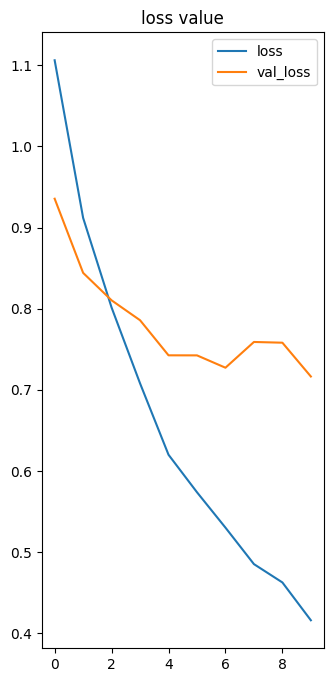

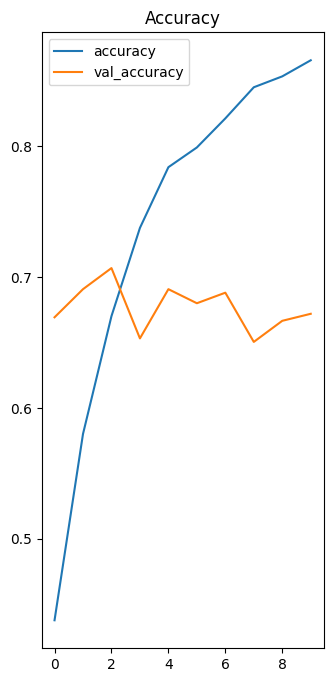

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.title('loss value')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
print('los:', history.history['loss'][-1])
print('val_loss:', history.history['val_loss'][-1])

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.title('Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
print('acc:', history.history['accuracy'][-1])
print('val_acc:', history.history['val_accuracy'][-1])
plt.show()

In [17]:
import os
model_version=max([int(i) for i in os.listdir("/content/data/models") + [0]])+1
model.save(f"/content/data/models/{model_version}")

In [18]:
model.save("../paper.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
